<a href="https://colab.research.google.com/github/up2113232/up2113232_coursework/blob/dev/Q3_folder/Q3_Activation_Functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How do activation functions affect a neural networks performance?

This notebook builds upon the previous Q2 notebook to explore how one of our neural network parameters affects its performance. From previous testing we see that our neural network didn't perform well when trying to predict psychological scores in the dataset.

We will continue this testing by using various activation functions to see how it affects the networks performance.

**Dataset:** Online Gaming Anxiety Data from Kaggle
**Target Variables:** GAD_T, SWL_T, SPIN_T

# What are activation functions?

An activation function takes the data from our dataset and creates a line which has a specific gradient for the corresponding value for each data point. This gradient tells our network how to learn:

- Steep gradients, tells our neural network to learn better from this data
- Shallow gradients, tells our neural network to learn less effectively from this data.

# Visualising the functions

Its much easier to see how each function treats the data than truing to imagine it, so lets create some plots to see the lines

In [26]:
# Here, we import the necessary libraries for our work.
# matplotlib.pyplot is used for creating visual plots, much like drawing charts.
import matplotlib.pyplot as plt
# numpy is a powerful library for working with numbers and mathematical operations.
import numpy as np

# We are importing a specific function called 'plot_activation_functions' from a file named 'functions.py'.
# This function will help us draw the graphs of different activation functions.
from functions import plot_activation_functions

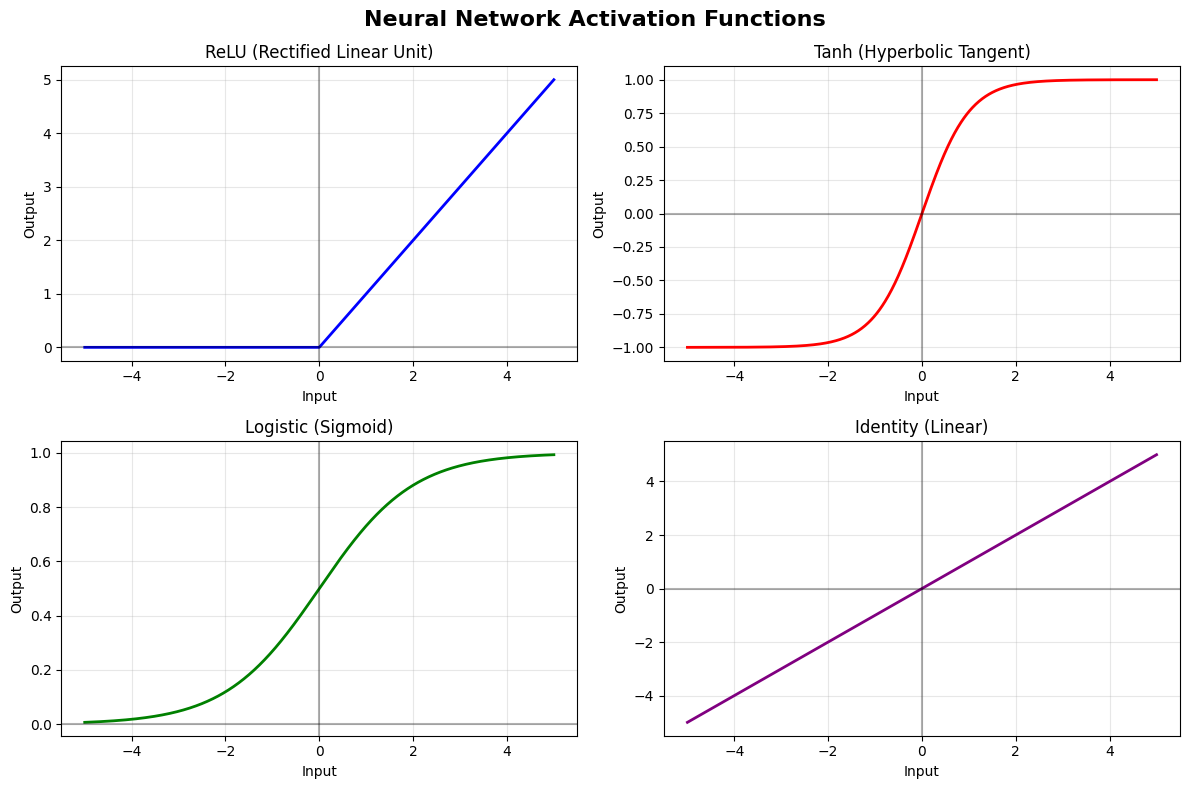

In [2]:
# This line calls the function we imported earlier.
# It creates and displays the visual plots of various activation functions.
plot_activation_functions()

# What we can tell from the plots

Relu:
- Doesn't learn at all from negative values, Gradient = 0
- Learns well from positve values, Gradient = 1

Tanh:
- Learns well from smaller values, steeper gradient near 0
- Learns less effectively with extreme values, shallower gradient away from 0

Logistic/Sigmoid:
- Works the same as tanh but all gradients are dampened
- Maximum gradient = 0.5 at x = 0

Linear:
- Gives all inputs a gradient of 1


# Testing

How will we approach our question?

We will use our initial code from Q2 to clean our data and setup our neural network. We will then use each activation function and measure its R2 value and the time taken to train our neural network.

Note* - due to our previous results we will do this experiment twice, one with early stopping and one without as we have seen that our network struggles to learn from this complex data as psychology is hard to predict. We will see if all activations stop after a similar amount of iterations and how this affects accuracy, and then see how the lack of early stopping affects the training time. This second experiment will have a fewer number of iterations to help speed up our experiment due to Colab's slower processing speed.

Let's begin by importing the rest of our libraries


In [3]:
# This section imports all the necessary libraries we need for our neural network experiment.

# 'sys' provides access to system-specific parameters and functions.
# We use it here to tell Python where to find our 'functions.py' file.
import sys
# 'os' allows us to interact with the operating system, for example, to handle file paths.
import os

# This line adds the parent directory to Python's search path.
# This means Python can find and use our 'functions.py' file, which contains helper functions.
sys.path.append('..')

# These are fundamental libraries for handling data and creating visualisations.
# 'pandas' is excellent for working with data tables, known as DataFrames.
import pandas as pd
# 'numpy' is used for numerical calculations, especially with arrays of numbers.
import numpy as np
# 'matplotlib.pyplot' is a comprehensive library for creating visualisations in Python.
import matplotlib.pyplot as plt
# 'seaborn' is built on top of matplotlib and provides a higher-level statistical graphics.
import seaborn as sns
# 'time' allows us to measure how long certain operations take.
import time

# These libraries are from scikit-learn, a popular machine learning toolkit.
# 'train_test_split' helps us divide our data into parts for training and testing our model.
# 'cross_val_score' is for evaluating a model's performance using a technique called cross-validation.
# 'GridSearchCV' is used for finding the best settings (hyperparameters) for a model.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# 'StandardScaler' is used to adjust the scale of our data, making it easier for the model to learn.
# 'LabelEncoder' helps convert text categories into numbers.
# 'MinMaxScaler' scales data to a specific range, often between 0 and 1.
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
# These are metrics we use to evaluate how well our regression models are performing.
# 'mean_squared_error' (MSE), 'mean_absolute_error' (MAE), and 'r2_score' (R-squared).
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# 'MLPRegressor' is the type of neural network model we will be using for predicting numerical values.
from sklearn.neural_network import MLPRegressor
# 'MultiOutputRegressor' is a tool that lets a single model predict multiple target values at once.
from sklearn.multioutput import MultiOutputRegressor

# This line tells Python to ignore any warning messages that might appear during execution.
# This keeps our output cleaner.
import warnings
warnings.filterwarnings('ignore')

Importing our functions

In [4]:
# From our functions.py file, we are importing specific helper functions.
# These functions organise common data processing steps, making our main code tidier.
# 'clean_data' is for initial tidying of the dataset, such as removing duplicates.
# 'encode_features' converts non-numerical data (like text categories) into numbers for the model.
# 'split_data' divides the dataset into training and testing sets.
# 'scale_features' normalises or standardises numerical information.
from functions import clean_data, encode_features, split_data, scale_features
# These functions are for plotting the R-squared (R2) and Mean Absolute Error (MAE) values.
from functions import plot_r2_values, plot_mae_values

Reading and storing the data

In [5]:
# This code attempts to load our dataset from a CSV file into a pandas DataFrame (a table-like structure).
# The 'encoding' parameter helps handle different character sets in the file.
# The 'try-except' block checks if the file exists.
# If the file is not found, it prints a message instead of crashing the program.
try:
  df = pd.read_csv('gaming_anxiety_data.csv', encoding='ISO-8859-1')

except FileNotFoundError:
  print(" File not found! Please upload your dataset first.")

Select our feature and target columns

In [6]:
# Here, we define the names of the columns that will be used as input features (X) for our neural network.
# These are the pieces of information the network will use to make its predictions.
feature_columns = ['GADE', 'Game', 'Hours', 'earnings', 'whyplay',
                   'streams', 'Narcissism', 'Gender',
                   'Age', 'Work', 'Playstyle']

# Next, we define the names of the columns we want our neural network to predict (y)
target_columns = ['GAD_T', 'SWL_T', 'SPIN_T']

# This line creates a new DataFrame containing only the selected feature and target columns.
# The '.copy()' ensures we are working with a separate copy of the data.
df = df[feature_columns + target_columns].copy()

Initial data cleaning

In [7]:
# This code calls the 'clean_data' function (which we imported from 'functions.py').
# This function performs initial data cleaning steps, such as removing duplicate rows.
# It also displays information about any missing values in the dataset.
# The cleaned data is then stored in a new DataFrame called 'df_cleaned_initial'.
print("Cleaning dataset...")
df_cleaned_initial = clean_data(df)

Cleaning dataset...
Missing values per column:
GADE          649
Game            0
Hours          30
earnings        0
whyplay         0
streams       100
Narcissism     23
Gender          0
Age             0
Work           38
Playstyle       0
GAD_T           0
SWL_T           0
SPIN_T        650
dtype: int64
Removed 0 rows with missing values
Removed 51 duplicate rows


Encoding our values and second clean

In [8]:
# In this step, we convert categorical (text-based) features into a numerical format.
# This is done using the 'encode_features' function, as neural networks typically require numerical inputs.
df_encoded = encode_features(df_cleaned_initial)

# We then remove any remaining rows that contain missing values (NaN - Not a Number).
# This ensures our final dataset, 'df_clean', is entirely numerical and has no gaps.
df_clean = df_encoded.dropna()

# These lines print a summary of missing values to confirm the cleaning process was successful.
print(f"\n Original Missing values: {df.isnull().sum().sum()}")
print(f" Missing values after cleaning and encoding: {df_clean.isnull().sum().sum()}")
# If any missing values still exist, this block will identify and print the columns that contain them.
if df_clean.isnull().sum().sum() > 0:
    print("Columns with missing values in df_clean:")
    print(df_clean.isnull().sum()[df_clean.isnull().sum() > 0])


 Original Missing values: 1490
 Missing values after cleaning and encoding: 0


Now we will encode our data using Standard scaling, this may cause some bias that we will explore later.

In [9]:
# First, we separate our dataset into features (X) and target variables (y).
# 'X' contains the input data, and 'y' contains the values we aim to predict.
X = df_clean[feature_columns]
y = df_clean[target_columns]

# We define the proportion of data to be used for testing (20%) and set a 'random_state'.
# Setting a 'random_state' ensures that our data split is the same every time we run the code, for consistent results.
test_size = 0.2
random_state = 42

# The 'split_data' function divides our features and targets into training and testing sets.
# 'X_train' and 'y_train' are used to train the model.
# 'X_test' and 'y_test' are used to evaluate how well the model performs on data it hasn't seen before.
X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size, random_state=random_state)

# We create a 'StandardScaler' object to standardise our feature data.
# Scaling is crucial for neural networks as it helps them learn faster and perform better.
scaler = StandardScaler()
# We 'fit' the scaler to our training features (X_train) to learn the scaling parameters.
# Then, we 'transform' both the training and test features (X_train and X_test) using these learned parameters.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# We create another 'StandardScaler' specifically for our target variables (y).
# It is good practice to scale target variables in regression tasks.
target_scaler = StandardScaler()
# We fit and transform the training target variables (y_train).
y_train_scaled = target_scaler.fit_transform(y_train)
# We then transform the test target variables (y_test) using the scaler that was fitted on the training targets.
y_test_scaled = target_scaler.transform(y_test)

Now is the time we will set up our neural network structure, we will create and train each neural network inside a for loop to train all models in one piece of code for convenience.

In [10]:
# We define a list of activation functions that we want to test in our neural network.
activation_funcs = ['relu', 'tanh', 'logistic', 'identity']
# This empty list will store the performance results for each activation function.
results = []

# This dictionary will store the 'loss curves' for each activation function.
# A loss curve shows how the model's error changes during training.
loss_curves = {}

# We loop through each activation function in our list to test them one by one.
for activation in activation_funcs:
    print(f"\n Testing {activation.upper()} activation...")

    # We create an 'MLPRegressor' model (a type of neural network for regression).
    model = MLPRegressor(
    # 'hidden_layer_sizes' defines the structure of the hidden layers.
    # For example, (128, 64, 32, 16) means four hidden layers with 128, 64, 32, and 16 neurons respectively.
    hidden_layer_sizes=(128, 64, 32, 16),
    # 'activation' specifies the activation function to use in the hidden layers.
    # We use the current 'activation' from our loop.
    activation = activation,
    # 'solver' is the algorithm used for optimising the model's weights. 'adam' is a popular and efficient choice.
    solver='adam',
    # 'batch_size' is the number of samples processed before the model's weights are updated. 16 is a common size.
    batch_size=16,
    # 'alpha' is a regularisation parameter (L2 penalty) that helps prevent the model from overfitting by penalising large weights.
    alpha=0.001,
    # 'learning_rate' determines how the learning rate changes over time. 'adaptive' reduces it when the model's performance on a validation set stops improving.
    learning_rate='adaptive',
    # 'learning_rate_init' is the starting learning rate. It controls the size of the steps taken during optimisation.
    learning_rate_init=0.01,
    # 'max_iter' sets the maximum number of training cycles (epochs) over the entire training data.
    max_iter=100,
    # 'random_state' ensures our results are reproducible by fixing the random number generator.
    random_state=42,
    # 'verbose=False' means the model will not print progress messages during training.
    verbose=False,
    # 'early_stopping=True' means training will stop early if the model's performance on a validation set does not improve.
    early_stopping=True,
    # 'validation_fraction' specifies the proportion of the training data to use as a validation set for early stopping.
    validation_fraction=0.1,
    # 'n_iter_no_change' is the maximum number of epochs with no improvement before early stopping is triggered.
    n_iter_no_change=20
)

    # We record the start time to measure how long the training takes.
    start_time = time.time()

    # This nested class is used to capture the loss values during training.
    class LossHistory:
        def __init__(self):
            self.losses = []
            self.training_time = None

    # We create an instance of our 'LossHistory' class.
    history = LossHistory()

    # This line trains the model using our scaled training features (X_train_scaled) and target values (y_train_scaled).
    model.fit(X_train_scaled, y_train_scaled)

    # We calculate the total time taken for training.
    training_time = time.time() - start_time
    history.training_time = training_time

    # We use the trained model to make predictions on the scaled test features (X_test_scaled).
    y_pred_scaled = model.predict(X_test_scaled)

    # We then 'inverse transform' the scaled predictions back to their original scale.
    # This makes the predictions understandable in the original units of GAD_T, SWL_T, and SPIN_T.
    y_pred = target_scaler.inverse_transform(y_pred_scaled)

    # We create a dictionary to store the metrics (performance measures) for the current activation function.
    metrics = {'activation': activation, 'training_time': training_time}

    # We loop through each of our target columns to calculate its individual performance metrics.
    for i, target in enumerate(target_columns):
        # We calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R2) for each target.
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
        r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])

        # We add these calculated metrics to our 'metrics' dictionary.
        metrics[f'{target}_MSE'] = mse
        metrics[f'{target}_MAE'] = mae
        metrics[f'{target}_R2'] = r2

    # If the model has a 'loss_curve_' attribute (which MLPRegressor does after training),
    # we store it in our 'loss_curves' dictionary for later visualisation.
    if hasattr(model, 'loss_curve_'):
        loss_curves[activation] = model.loss_curve_

    # Finally, we add the 'metrics' dictionary for the current activation function to our 'results' list.
    results.append(metrics)

    # We print the training time and the performance metrics for each target variable.
    print(f"  Training time: {training_time:.2f} seconds")
    for target in target_columns:
        print(f"  {target}: MSE={metrics[f'{target}_MSE']:.3f}, MAE={metrics[f'{target}_MAE']:.3f}, R2={metrics[f'{target}_R2']:.3f}")


 Testing RELU activation...
  Training time: 12.10 seconds
  GAD_T: MSE=12.706, MAE=2.712, R2=0.407
  SWL_T: MSE=42.110, MAE=5.385, R2=0.163
  SPIN_T: MSE=150.962, MAE=9.650, R2=0.137

 Testing TANH activation...
  Training time: 13.79 seconds
  GAD_T: MSE=13.081, MAE=2.789, R2=0.389
  SWL_T: MSE=42.142, MAE=5.383, R2=0.162
  SPIN_T: MSE=153.310, MAE=9.860, R2=0.124

 Testing LOGISTIC activation...
  Training time: 36.21 seconds
  GAD_T: MSE=13.059, MAE=2.707, R2=0.390
  SWL_T: MSE=41.684, MAE=5.344, R2=0.172
  SPIN_T: MSE=151.452, MAE=9.589, R2=0.135

 Testing IDENTITY activation...
  Training time: 7.11 seconds
  GAD_T: MSE=18.019, MAE=3.093, R2=0.159
  SWL_T: MSE=45.886, MAE=5.646, R2=0.088
  SPIN_T: MSE=170.018, MAE=10.038, R2=0.028


Let's convert our results to a pandas DataFrame for easier manipulation

In [11]:
# We convert our list of results into a pandas DataFrame for easier viewing and manipulation.
results_df = pd.DataFrame(results)
# We print a header for our experiment results.
print("EXPERIMENT RESULTS")
# We print the DataFrame, rounding the numbers to 4 decimal places and without showing the index column.
print(results_df.round(4).to_string(index=False))

EXPERIMENT RESULTS
activation  training_time  GAD_T_MSE  GAD_T_MAE  GAD_T_R2  SWL_T_MSE  SWL_T_MAE  SWL_T_R2  SPIN_T_MSE  SPIN_T_MAE  SPIN_T_R2
      relu        12.1000    12.7065     2.7121    0.4068    42.1095     5.3855    0.1631    150.9622      9.6499     0.1373
      tanh        13.7869    13.0813     2.7886    0.3893    42.1423     5.3827    0.1624    153.3098      9.8596     0.1239
  logistic        36.2094    13.0587     2.7066    0.3904    41.6842     5.3443    0.1715    151.4525      9.5888     0.1345
  identity         7.1134    18.0195     3.0927    0.1588    45.8855     5.6464    0.0880    170.0183     10.0380     0.0284


Now that we have our results, we want to visualise them. For each plot, we will have 4 bars, one for each activation functions. We will look at R2 and MAE like we saw in the previous notebooks so that we can compare. We won't be visualising time taken just yet as each model may have stopped at different number of iterations.

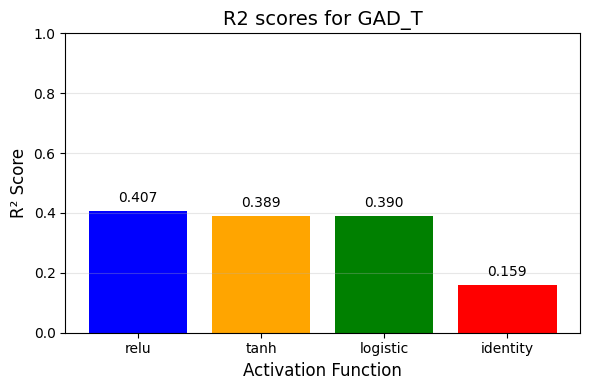

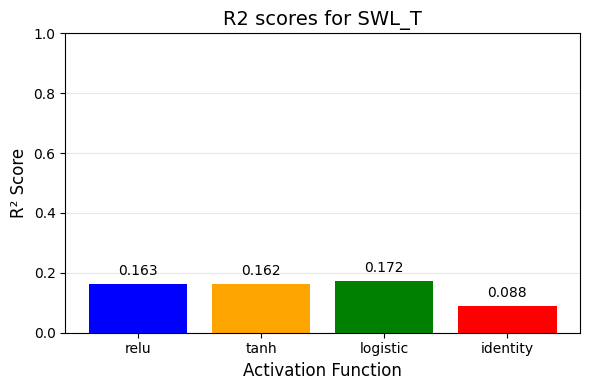

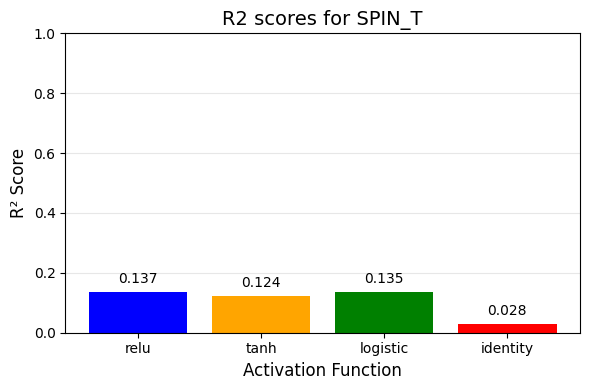

In [12]:
# This section creates bar charts to compare the R-squared (R2) scores for each activation function.

# We loop through each target variable to create a separate plot for each.
for idx, target in enumerate(target_columns):
    # We create a new figure and a single plot (subplot) for each target variable.
    # 'figsize' sets the width and height of the plot in inches.
    fig, ax = plt.subplots(figsize=(6, 4))

    # We get the names of the activation functions from our results DataFrame.
    activations = results_df['activation']
    # We extract the R2 scores for the current target variable.
    r2_scores = results_df[f'{target}_R2']

    # We create the bar chart using the activation functions and their R2 scores.
    # 'color' assigns specific colours to each bar.
    bars = ax.bar(activations, r2_scores, color=['blue', 'orange', 'green', 'red'])
    # We set the title of the plot, including the name of the target variable.
    ax.set_title(f'R2 scores for {target}', fontsize=14)
    # We label the x-axis as 'Activation Function'.
    ax.set_xlabel('Activation Function', fontsize=12)
    # We label the y-axis as 'R² Score'.
    ax.set_ylabel('R² Score', fontsize=12)
    # We set the y-axis limit from 0 to 1, as R2 scores typically fall within this range.
    ax.set_ylim([0, 1])
    # We add a grid to the y-axis for easier reading of the values.
    ax.grid(True, axis='y', alpha=0.3)

    # This loop adds the exact R2 score value on top of each bar.
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

    # 'plt.tight_layout()' automatically adjusts plot parameters for a tight layout, preventing labels from overlapping.
    plt.tight_layout()
    # We display the plot.
    plt.show()

Here we see that our networks all performed similarly except identity/linear. This likely comes from similar reasons to my conclusions from Q2. The values we are trying to predict are very complex, people's psychology. Even with all the facts a neural network would struggle to accurately predict how a person's brain functions and we are just working with 11 very niche variables.

The result produced by identity is interesting, while every other function produced similar results, identity was significantly worse across the board, being worse than random guessing. This is likely due to not considering the rates or not picking up obvious patterns the other functions did.

Doing the same for MAE values


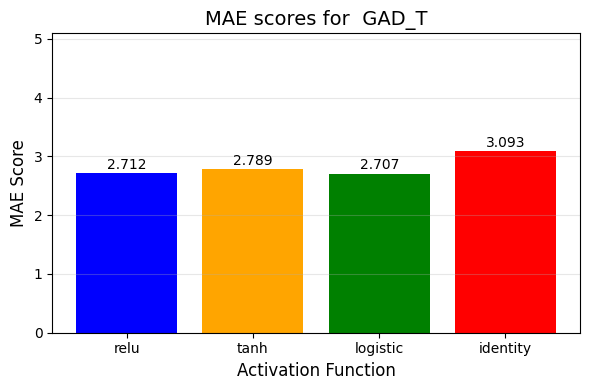

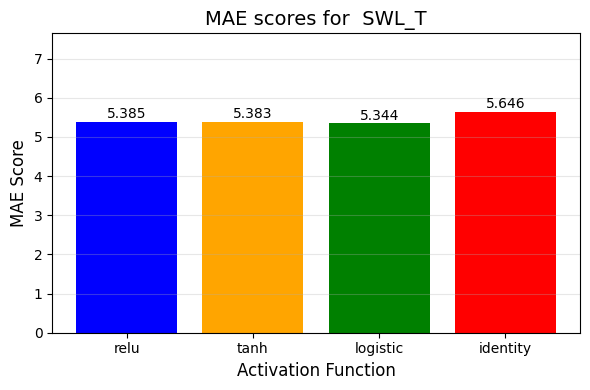

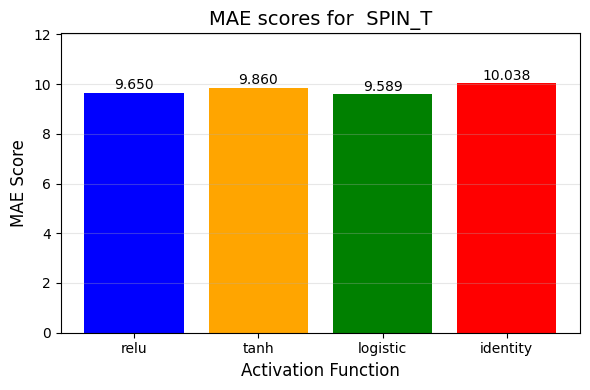

In [13]:
# This section creates bar charts to compare the Mean Absolute Error (MAE) scores for each activation function.

# We loop through each target variable to create a separate plot for each.
for idx, target in enumerate(target_columns):
    # We create a new figure and a single plot (subplot) for each target variable.
    # 'figsize' sets the width and height of the plot in inches.
    fig, ax = plt.subplots(figsize=(6, 4))

    # We get the names of the activation functions from our results DataFrame.
    activations = results_df['activation']
    # We extract the MAE scores for the current target variable.
    MAE_scores = results_df[f'{target}_MAE']

    # We create the bar chart using the activation functions and their MAE scores.
    # 'color' assigns specific colours to each bar.
    bars = ax.bar(activations, MAE_scores, color=['blue', 'orange', 'green', 'red'])
    # We set the title of the plot, including the name of the target variable.
    ax.set_title(f'MAE scores for  {target}', fontsize=14)
    # We label the x-axis as 'Activation Function'.
    ax.set_xlabel('Activation Function', fontsize=12)
    # We label the y-axis as 'MAE Score'.
    ax.set_ylabel('MAE Score', fontsize=12)
    # We find the maximum MAE score for the current target to set the y-axis limit dynamically.
    y_max = MAE_scores.max()
    # We set the y-axis limit, adding a small buffer (+2) above the maximum score for better visualisation.
    ax.set_ylim([0, y_max + 2])
    # We add a grid to the y-axis for easier reading of the values.
    ax.grid(True, axis='y', alpha=0.3)

    # This loop adds the exact MAE score value on top of each bar.
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

    # 'plt.tight_layout()' automatically adjusts plot parameters for a tight layout, preventing labels from overlapping.
    plt.tight_layout()
    # We display the plot.
    plt.show()

The context for our MAE lies within the ranges for each target.

GAD:
- 0-21

SWL:
- 5-35

SPIN:
- 0-68

This highlights the idea that our network is guessing at random, as SWL and SPIN have an error range of around 33% of the total range. (Remember MAE is +- value).

GAD seems to hint at a small amount of pattern recognition, which is reinforced by the R2 values as GAD was significantly higher than the other 2 sets of results. However, this was regardless of activation function if we ignore identities poor performance for all 3.

Now lets look at our loss curve

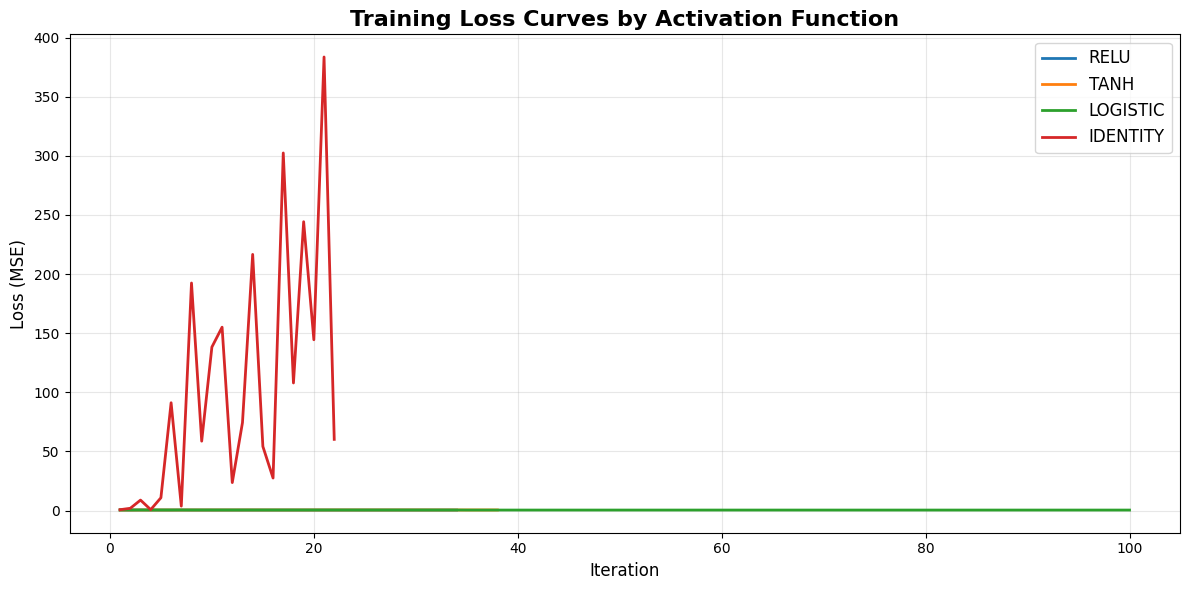

In [14]:
# This section plots the training loss curves for each activation function.
# The 'loss_curves' dictionary contains the loss values recorded during the first experiment.

# We first check if the 'loss_curves' dictionary contains any data.
if loss_curves:
    # We create a new figure for our plot, setting its size.
    plt.figure(figsize=(12, 6))
    # We loop through each activation function and its corresponding loss values.
    for activation, losses in loss_curves.items():
        # We plot the loss values over the training iterations.
        # 'range(1, len(losses) + 1)' creates the x-axis (iteration numbers).
        # 'label' is used for the legend, and 'linewidth' sets the thickness of the line.
        plt.plot(range(1, len(losses) + 1), losses, label=activation.upper(), linewidth=2)

    # We set the title of the plot to describe what is being shown.
    plt.title('Training Loss Curves by Activation Function', fontsize=16, fontweight='bold')
    # We label the x-axis as 'Iteration'.
    plt.xlabel('Iteration', fontsize=12)
    # We label the y-axis as 'Loss (MSE)' (Mean Squared Error).
    plt.ylabel('Loss (MSE)', fontsize=12)
    # We display a legend to identify which line belongs to which activation function.
    plt.legend(fontsize=12)
    # We add a grid to the plot for easier reading of the values.
    plt.grid(True, alpha=0.3)

    # 'plt.tight_layout()' automatically adjusts plot parameters for a tight layout.
    plt.tight_layout()
    # We display the plot.
    plt.show()

The loss curve is a way to visualise how the neural network learned in its training process, however, this figure above is dominated by identity which is shown to randomly fluctuate at large margins. To see the other losses lets look at a plot without identity.

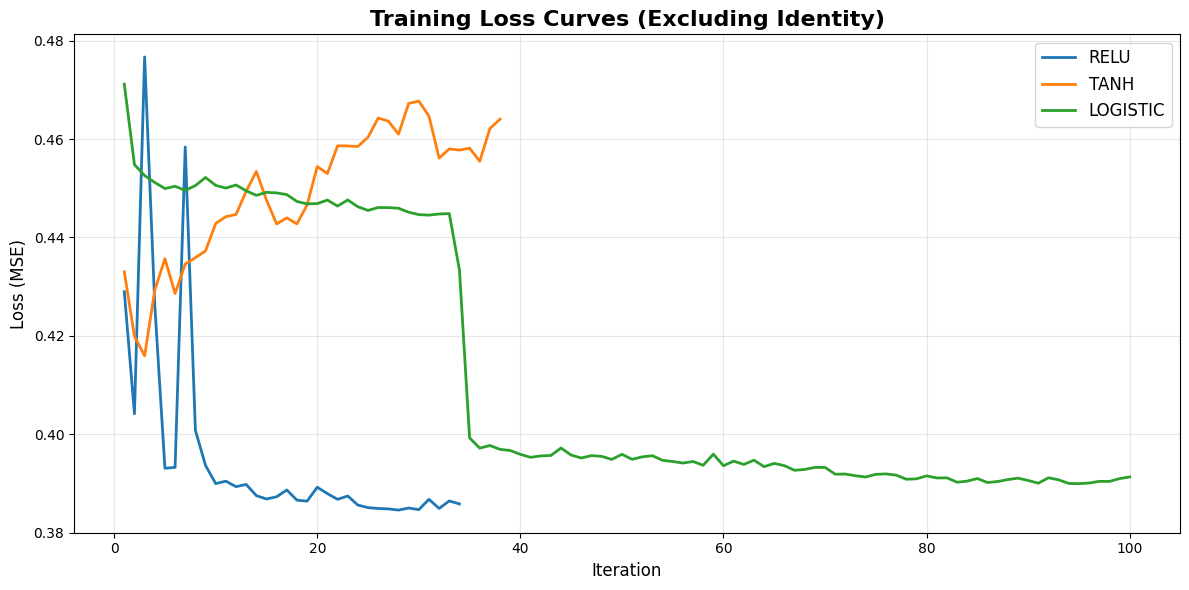

In [16]:
import matplotlib.pyplot as plt

# This code generates a training loss curve plot that specifically excludes the 'identity' activation function.
# This allows for a clearer view of the other curves

# 1. We create a new dictionary called 'filtered_loss_curves'.
# This dictionary contains the loss curves from the original 'loss_curves' dictionary,
# but it explicitly excludes the entry for the 'identity' activation function.
filtered_loss_curves = {key: value for key, value in loss_curves.items() if key != 'identity'}

# 2. We create a new figure and axes for our plot, setting its size.
plt.figure(figsize=(12, 6))

# 3. We loop through the 'filtered_loss_curves' dictionary.
# For each activation function (ReLU, Tanh, Logistic) and its corresponding loss values,
# we plot them on the figure. 'range(1, len(losses) + 1)' generates the x-axis values (iterations).
for activation, losses in filtered_loss_curves.items():
    plt.plot(range(1, len(losses) + 1), losses, label=activation.upper(), linewidth=2)

# 4. We set the title of the plot to indicate that the 'identity' function is excluded.
plt.title('Training Loss Curves (Excluding Identity)', fontsize=16, fontweight='bold')
# We label the x-axis as 'Iteration' and the y-axis as 'Loss (MSE)'.
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)

# 5. We display a legend to show which line corresponds to which activation function.
plt.legend(fontsize=12)

# 6. We add a grid to the plot for improved readability.
plt.grid(True, alpha=0.3)

# 7. 'plt.tight_layout()' automatically adjusts plot parameters to prevent labels or titles from overlapping.
# Finally, 'plt.show()' displays the generated plot.
plt.tight_layout()
plt.show()

This plot gives us deeper insight into the other functions.

Relu:
- This curve shows a relatively rapid decrease in loss during the initial iterations, with some fluctuations. It then stabilises and continues to decrease slowly reaching the lowest loss value among the three and maintaining a relatively stable pattern. This suggests that ReLU is converging the best.

Tanh:

- also shows an initial decrease in loss but then starts to increase and fluctuate at a higher loss value compared to ReLU. This indicates that Tanh might be struggling to converge to a lower minimum and possibly overshooting or getting stuck in local minima.

Logistic:
- The Logistic curve initially decreases with some fluctuations, then has a sharp drop around iteration 35, after which it stabilizes at a relatively low loss value, though slightly higher than ReLU. The large drop indicates a point where the model made a significant learning step or found a better path towards minimizing the loss. After this drop, it shows good stability.



#Training times

Now lets measure and compare training times, to make this fair we will retrain each model with the more iterations by increasing the number of iterations before early stopping. This will give us a better comparison to how fast each function converges with more rigorous training

In [20]:
# This section performs a second experiment, similar to the first, but with adjusted training parameters.
# The main changes are increasing 'n_iter_no_change'
# This is to see how longer training affects the performance and convergence of each activation function.

# We initialise an empty list to store the results of this second experiment.
results2 = []

# This dictionary will store the loss curves for each activation function from this second experiment.
loss_curves2 = {}

# We loop through each activation function to test its performance with the new settings.
for activation in activation_funcs:
    print(f"\n Testing {activation.upper()} activation...")

    # We create an 'MLPRegressor' model with similar architecture but modified training parameters.
    model = MLPRegressor(
    # The hidden layers remain the same: (128, 64, 32, 16) neurons.
    hidden_layer_sizes=(128, 64, 32, 16),
    # The activation function is set based on the current iteration of the loop.
    activation = activation,
    # The 'adam' optimiser is used.
    solver='adam',
    # The batch size is 16 samples.
    batch_size=16,
    # L2 regularisation term parameter.
    alpha=0.001,
    # Adaptive learning rate strategy.
    learning_rate='adaptive',
    # Initial learning rate.
    learning_rate_init=0.01,
    # The maximum number of training epochs is set to 75.
    max_iter=75,
    # Random state for reproducibility.
    random_state=42,
    # Verbose output is set to False (no detailed progress messages).
    verbose=False,
    # Early stopping is enabled again to allow models to stop if no improvement, but with a larger patience.
    early_stopping=True,
    # 10% of the training data is used for validation.
    validation_fraction=0.1,
    # The model will stop if the validation score does not improve for 40 consecutive epochs.
    n_iter_no_change=40
)

    # We record the start time to measure the training duration.
    start_time = time.time()

    # This nested class is used to store loss values and training time.
    class LossHistory:
        def __init__(self):
            self.losses = []
            self.training_time = None

    # We create an instance of 'LossHistory'.
    history = LossHistory()

    # The model is trained using the scaled training data.
    model.fit(X_train_scaled, y_train_scaled)

    # We calculate the total training time.
    training_time = time.time() - start_time
    history.training_time = training_time

    # Predictions are made on the scaled test data.
    y_pred_scaled = model.predict(X_test_scaled)

    # The scaled predictions are converted back to their original scale for interpretability.
    y_pred = target_scaler.inverse_transform(y_pred_scaled)

    # We create a dictionary to store the performance metrics for the current activation function.
    metrics2 = {'activation': activation, 'training_time': training_time}

    # We loop through each target variable to calculate and store its specific metrics.
    for i, target in enumerate(target_columns):
        # Mean Squared Error, Mean Absolute Error, and R-squared are calculated.
        mse2 = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        mae2 = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
        r22 = r2_score(y_test.iloc[:, i], y_pred[:, i])

        # These metrics are added to the 'metrics2' dictionary.
        metrics2[f'{target}_MSE'] = mse2
        metrics2[f'{target}_MAE'] = mae2
        metrics2[f'{target}_R2'] = r22

    # If the model has a 'loss_curve_' attribute, its loss curve is stored in 'loss_curves2'.
    if hasattr(model, 'loss_curve_'):
        loss_curves2[activation] = model.loss_curve_

    # The metrics for the current activation function are added to the 'results2' list.
    results2.append(metrics2)

    # The training time and metrics for each target are printed.
    print(f"  Training time: {training_time:.2f} seconds")
    for target in target_columns:
        print(f"  {target}: MSE={metrics2[f'{target}_MSE']:.3f}, MAE={metrics2[f'{target}_MAE']:.3f}, R2={metrics2[f'{target}_R2']:.3f}")


 Testing RELU activation...
  Training time: 24.47 seconds
  GAD_T: MSE=12.706, MAE=2.712, R2=0.407
  SWL_T: MSE=42.110, MAE=5.385, R2=0.163
  SPIN_T: MSE=150.962, MAE=9.650, R2=0.137

 Testing TANH activation...
  Training time: 21.31 seconds
  GAD_T: MSE=13.081, MAE=2.789, R2=0.389
  SWL_T: MSE=42.142, MAE=5.383, R2=0.162
  SPIN_T: MSE=153.310, MAE=9.860, R2=0.124

 Testing LOGISTIC activation...
  Training time: 26.84 seconds
  GAD_T: MSE=12.787, MAE=2.685, R2=0.403
  SWL_T: MSE=42.636, MAE=5.411, R2=0.153
  SPIN_T: MSE=151.369, MAE=9.564, R2=0.135

 Testing IDENTITY activation...
  Training time: 13.21 seconds
  GAD_T: MSE=18.019, MAE=3.093, R2=0.159
  SWL_T: MSE=45.886, MAE=5.646, R2=0.088
  SPIN_T: MSE=170.018, MAE=10.038, R2=0.028


Here's our results again

In [21]:
# We convert the list of results from our second experiment into a pandas DataFrame.
results2_df = pd.DataFrame(results2)
# We print a header for the experiment results.
print("EXPERIMENT RESULTS")
# We print the DataFrame, rounding numerical values to 4 decimal places and hiding the index column.
print(results2_df.round(4).to_string(index=False))

EXPERIMENT RESULTS
activation  training_time  GAD_T_MSE  GAD_T_MAE  GAD_T_R2  SWL_T_MSE  SWL_T_MAE  SWL_T_R2  SPIN_T_MSE  SPIN_T_MAE  SPIN_T_R2
      relu        24.4696    12.7065     2.7121    0.4068    42.1095     5.3855    0.1631    150.9622      9.6499     0.1373
      tanh        21.3079    13.0813     2.7886    0.3893    42.1423     5.3827    0.1624    153.3098      9.8596     0.1239
  logistic        26.8366    12.7872     2.6846    0.4031    42.6359     5.4112    0.1526    151.3688      9.5641     0.1350
  identity        13.2096    18.0195     3.0927    0.1588    45.8855     5.6464    0.0880    170.0183     10.0380     0.0284


Now lets look at our training time comparisons

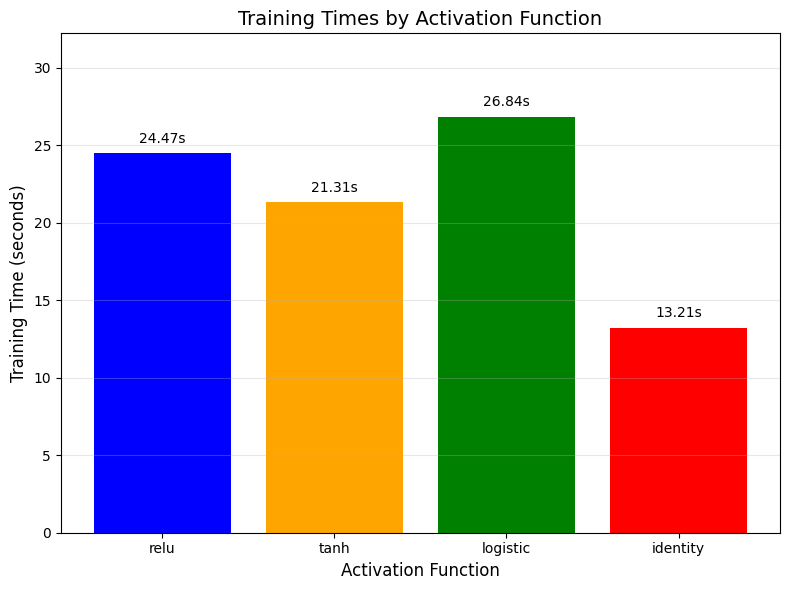

In [22]:
# This section creates a bar chart to visually compare the training times of different activation functions.

# We create a DataFrame from the results of the second experiment.
results2_df = pd.DataFrame(results2)

# We create a new figure and a single plot (subplot) for our bar chart.
# 'figsize' sets the width and height of the plot in inches.
fig, ax = plt.subplots(figsize=(8, 6))

# We extract the names of the activation functions from our DataFrame.
activations = results2_df['activation']
# We extract the training times for each activation function.
training_times = results2_df['training_time']

# We create the bar chart using the activation functions and their training times.
# 'color' assigns specific colours to each bar.
bars = ax.bar(activations, training_times, color=['blue', 'orange', 'green', 'red'])
# We set the title of the plot.
ax.set_title('Training Times by Activation Function', fontsize=14)
# We label the x-axis as 'Activation Function'.
ax.set_xlabel('Activation Function', fontsize=12)
# We label the y-axis as 'Training Time (seconds)'.
ax.set_ylabel('Training Time (seconds)', fontsize=12)
# We set the y-axis limit, adding a buffer (20% of the maximum time) for better visual spacing.
ax.set_ylim([0, training_times.max() * 1.2])
# We add a grid to the y-axis for easier reading of the values.
ax.grid(True, axis='y', alpha=0.3)

# This loop adds the exact training time value on top of each bar.
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.2f}s', ha='center', va='bottom', fontsize=10)

# 'plt.tight_layout()' adjusts plot parameters for a tight layout, preventing labels from overlapping.
plt.tight_layout()
# We display the plot.
plt.show()

#What do our finding tell us

Relu:
- ReLU was the second slowest, which surprising given its reputation for significantly faster training compared to sigmoid/tanh. However, it's not too different from Logistic in this specific setup, suggesting that other factors like the network architecture or dataset complexity might also be influencing the training time.

Tanh:
-  Tanh is considerably faster than both Logistic and ReLU in this experiment. This is an interesting pattern, as Tanh suffers from vanishing gradients but often performs better than Logistic due to its zero-centered output. The difference here is quite significant.

Logistic:
- This is the slowest activation function to train, taking slightly longer than the ReLu. This is an expected pattern for sigmoid-like functions due to the vanishing gradient problem, especially in deeper networks, which can slow down convergence.

Identity:
- The Identity activation function is the fastest to train by a large margin. This is an expected pattern, as the identity function simply passes the input directly, meaning there's less computation involved per neuron and no complex gradient calculations like those in non-linear activations. However, as we observed in the R2 scores, this speed comes at a significant cost to model performance.

Finally, lets observe the loss curves for these findings and see if the increased number of iterations on average shows us any more patterns

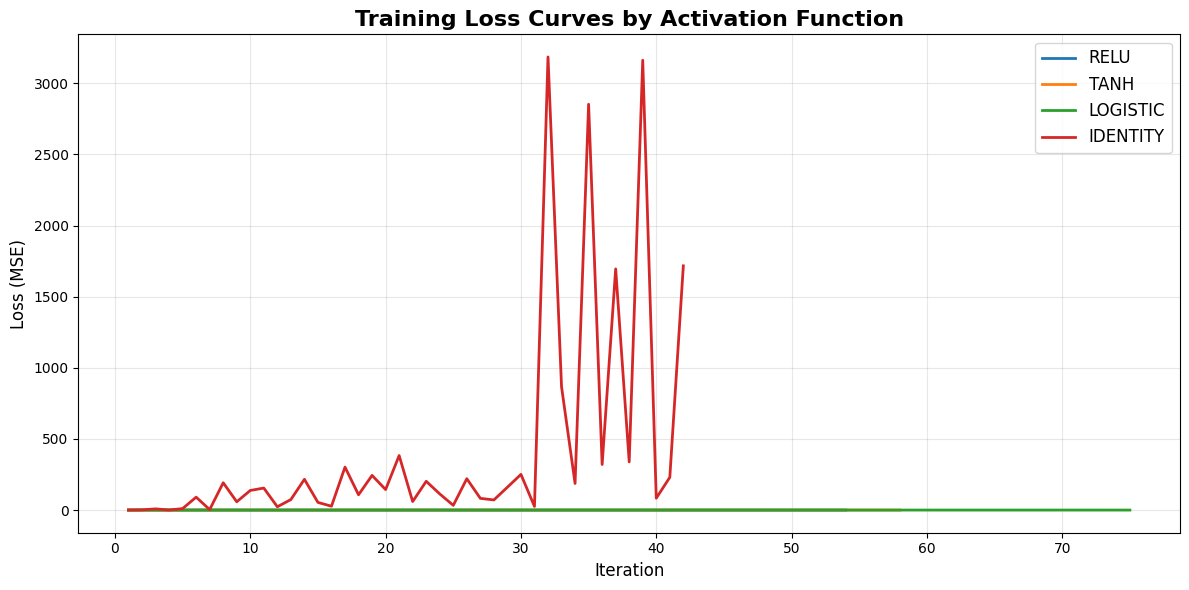

In [24]:
# This section plots the training loss curves for each activation function from the second experiment.
# The 'loss_curves2' dictionary contains the loss values recorded during this experiment.

# We first check if the 'loss_curves2' dictionary contains any data.
if loss_curves2:
    # We create a new figure for our plot, setting its size.
    plt.figure(figsize=(12, 6))
    # We loop through each activation function and its corresponding loss values.
    for activation, losses in loss_curves2.items():
        # We plot the loss values over the training iterations.
        # 'range(1, len(losses) + 1)' creates the x-axis (iteration numbers).
        # 'label' is used for the legend, and 'linewidth' sets the thickness of the line.
        plt.plot(range(1, len(losses) + 1), losses, label=activation.upper(), linewidth=2)

    # We set the title of the plot.
    plt.title('Training Loss Curves by Activation Function', fontsize=16, fontweight='bold')
    # We label the x-axis as 'Iteration'.
    plt.xlabel('Iteration', fontsize=12)
    # We label the y-axis as 'Loss (MSE)'.
    plt.ylabel('Loss (MSE)', fontsize=12)
    # We display a legend to identify which line belongs to which activation function.
    plt.legend(fontsize=12)
    # We add a grid to the plot for easier reading of the values.
    plt.grid(True, alpha=0.3)

    # 'plt.tight_layout()' automatically adjusts plot parameters for a tight layout.
    plt.tight_layout()
    # We display the plot.
    plt.show()

Again this plot is dominated by large identity flucuations so lets filter these out

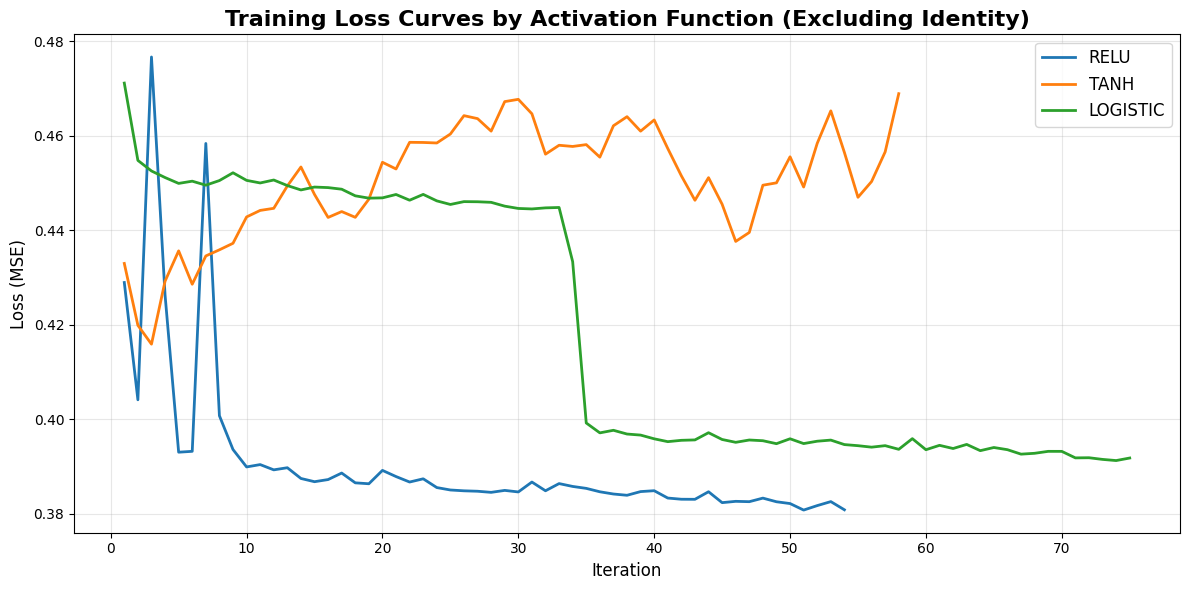

In [25]:
# This code generates a training loss curve plot that specifically excludes the 'identity' activation function from the second experiment.
# This allows for a clearer view of the other curves

# We check if the 'loss_curves2' dictionary contains any data from the second experiment.
if loss_curves2:
    # We create a new dictionary called 'filtered_loss_curves2'.
    # This dictionary contains the loss curves from 'loss_curves2',
    # but it explicitly excludes the entry for the 'identity' activation function.
    filtered_loss_curves2 = {key: value for key, value in loss_curves2.items() if key != 'identity'}

    # We create a new figure and axes for our plot, setting its size.
    plt.figure(figsize=(12, 6))
    # We loop through the 'filtered_loss_curves2' dictionary.
    # For each activation function (ReLU, Tanh, Logistic) and its corresponding loss values,
    # we plot them on the figure. 'range(1, len(losses) + 1)' generates the x-axis values (iterations).
    for activation, losses in filtered_loss_curves2.items():
        plt.plot(range(1, len(losses) + 1), losses, label=activation.upper(), linewidth=2)

    # We set the title of the plot to indicate that the 'identity' function is excluded.
    plt.title('Training Loss Curves by Activation Function (Excluding Identity)', fontsize=16, fontweight='bold')
    # We label the x-axis as 'Iteration' and the y-axis as 'Loss (MSE)'.
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Loss (MSE)', fontsize=12)
    # We display a legend to show which line corresponds to which activation function.
    plt.legend(fontsize=12)
    # We add a grid to the plot for improved readability.
    plt.grid(True, alpha=0.3)

    # 'plt.tight_layout()' automatically adjusts plot parameters to prevent labels or titles from overlapping.
    plt.tight_layout()
    # Finally, 'plt.show()' displays the generated plot.
    plt.show()

Now we made to complete more iterations we see an extended version of the original loss curves.

ReLu:
- Continues its convergence lowering the error at a steady rate.

Tanh:
- Continues to flucuate until the adaptive learning parameter stops the learning early. This hints that no matter the number of iterations tanh will struggle to predict the targets with the dataset. However there is a steady decline around the 45th iteration. Which could suggest there would be an eventual convergence later in the training.

Logistic:
- No changes.

#Conclusions

The big take away from my experiment is that activation functions heavily vary in effectiveness depending on the dataset you are using. In this experiment we are trying to predict targets with very complex patterns that a simple neural network isn't able to find and apply to its predictions.

For time efficency ReLu and Tanh proved to be better than logistic. They converge much earlier than logistic and therefore take less time to train without losing accuracy. Although identity was much faster, it sacrifices accuracy for speed.

#How would I change the experiment if I were to repeat it?

If I were to repeat this test I have multiple optimisations I would implement.
- I would choose a different data set with clearer patterns in the data. This is to test an activation function's ability to quickly identify and learn patterns.
- Replace identity with a modern activation function. This is because identity acted as a control function in this experiment, showing how the non-linear functions performed better and how fast the most simple functions can be.